# Predicting Newsletter Subscription Based on Player Age and Playtime

---

## General Overview
- **Number of Observations (Rows):** 400
- **Number of Variables (Columns):** 7

---

## Potential Issues
- Missing values in some columns (e.g., `Age` and `played_hours`).
- Some columns such as `hashedEmail` and  `Name` may not be useful for analysis due to their hashed nature.
- Possible outliers in `played_hours` (e.g., values like 218.1 and 223.1).

---

## Variables Summary

| **Variable Name** | **Data Type** | **Description**                                                                 | **Potential Issues**                                                                 |
|--------------------|---------------|---------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| **experience**     | Categorical   | Player's experience level ("Beginner," "Amateur," "Regular," "Veteran," "Pro"). | No major issues.                                                                    |
| **subscribe**      | Boolean       | Indicates whether the player has subscribed (TRUE or FALSE).                    | No major issues.                                                                    |
| **hashedEmail**    | String        | Hashed email address of the player.                                             | Not useful for analysis.                                                            |
| **played_hours**   | Numeric       | Total hours played by the player.                                               | Missing values. |
| **name**           | String        | Name of the player.                                                             | Not useful for analysis.                                       |
| **gender**         | Categorical   | Gender of the player (e.g., "Male," "Female," "Non-binary," "Prefer not to say").| Inconsistent categories (e.g., "Two-Spirited," "Agender"). May need standardization.|
| **Age**            | Numeric       | Age of the player.                                                              | Some unrealistic values (e.g., 9, 49, 50). Missing values.                          |

---

## Key Insights

### Demographics:
- The majority of players are male (70%), with a small percentage identifying as non-binary, agender, or preferring not to say.

### Gaming Behavior:
- Most players have played very few hours (median = 0.1), but there are extreme outliers (e.g., 223.1 hours).
- The most common experience level is "Amateur," followed by "Veteran" and "Regular."

### Subscription Status:
- Approximately 75% of players are subscribed, indicating a high subscription rate.

---

## Potential Issues

### Data Quality:
- Missing values in `Age` and `played_hours`.
- Outliers in `played_hours` and `Age` that may need to be addressed.
- Inconsistent gender categories that may require standardization.

### Data Collection:
- The dataset may suffer from self-reporting bias (e.g., players may misreport their age or hours played).
- The hashed email column (`hashedEmail`) is not useful for analysis and could be removed.
- The `name` column is also not useful for analysis and could be removed.

### Ethical Concerns:
- The dataset includes sensitive information (e.g., gender, age), which should be handled carefully to ensure privacy.

### Summary:
- This report will examine data from collected from a UBC led Minecraft server. The data gathered includes variables such as the amount of hours played on the server, age of the player, gender, experience, email and name. This report will pose the following question: Can age and hours played act as predictor for whether a player will subscribe to the newsletter. The dataset used to answer this question was players.csv which contains info on whether the player subscribes to the newsletter the name of the players as well as their gender and age, in addition this dataset contained the amount of hours played and the experience level of the players. Of these variables the only ones used for this examination was the hours played the age and whether the player subcribes or not. 

---


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
url <- "https://raw.githubusercontent.com/g-amadorz/dsci-project/refs/heads/main/data/players.csv"

players <- read_csv(url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [4]:
players_clean <- players |>
    mutate(age = Age, subscribe = as.factor(subscribe)) |>
    select(age, played_hours, subscribe) |>
    drop_na()

glimpse(players_clean)


Rows: 194
Columns: 3
$ age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ subscribe    <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


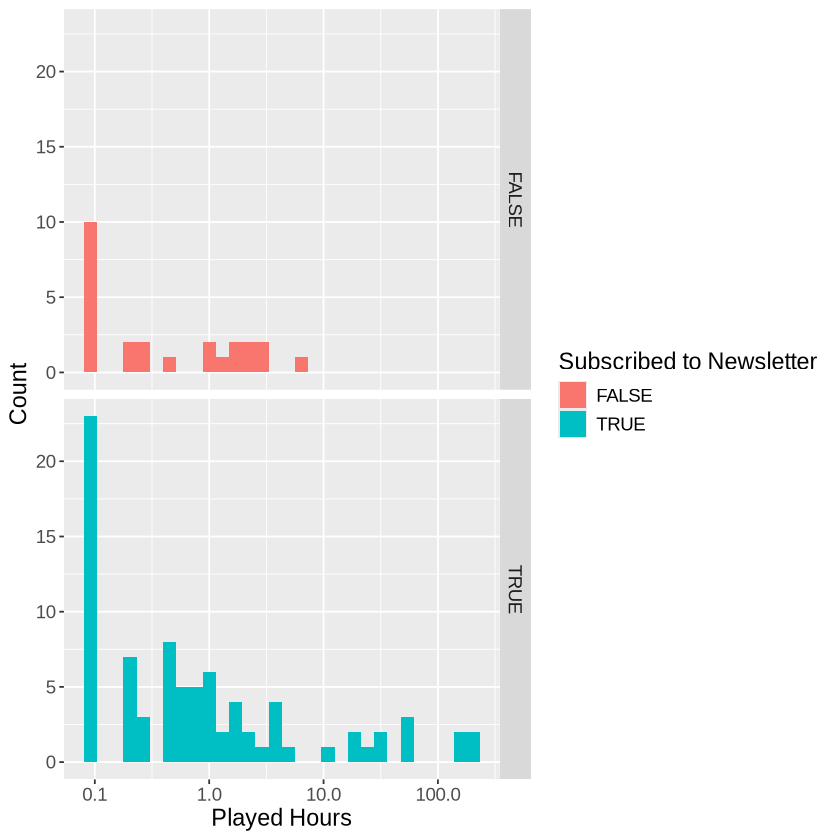

In [5]:
hours_played_hist <- players_clean |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram() +
    scale_x_log10() +
    facet_grid(rows=vars(subscribe)) +
    labs(x = "Played Hours", fill = "Subscribed to Newsletter", y = "Count") +
    theme(text = element_text(size = 14))

hours_played_hist
    

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range
(`stat_density()`).”


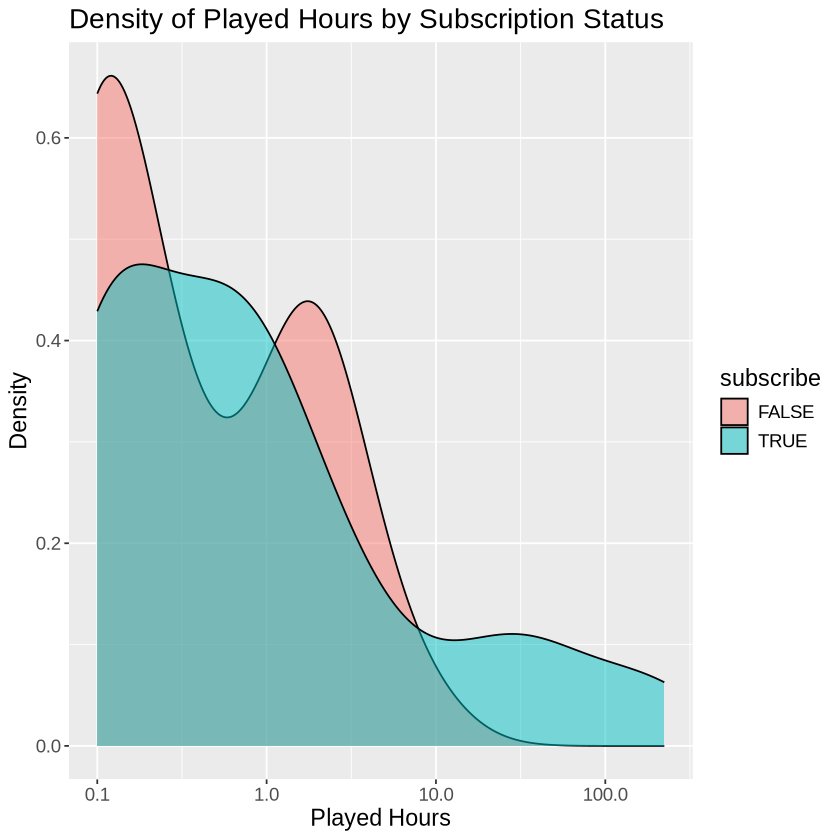

In [6]:
hours_played_density_plot <- players_clean |>
  ggplot(aes(x = played_hours, fill = subscribe)) +
  geom_density(alpha = 0.5) +
    scale_x_log10() +
  labs(title = "Density of Played Hours by Subscription Status",
       x = "Played Hours",
       y = "Density") +
    theme(text = element_text(size = 14))

hours_played_density_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


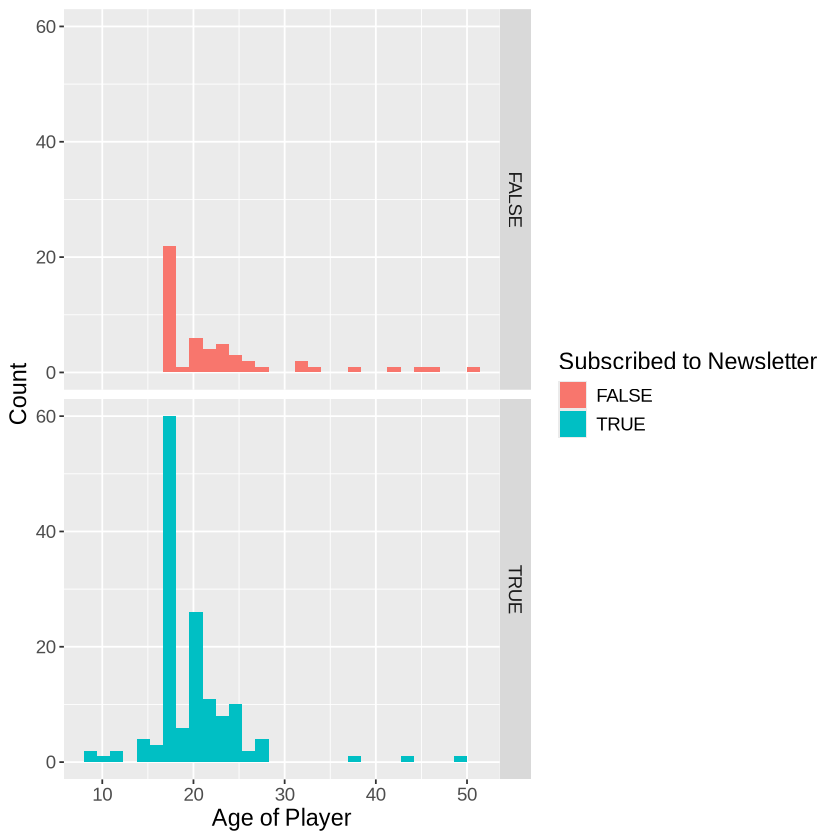

In [7]:
age_hist <- players_clean |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram() +
    facet_grid(rows=vars(subscribe)) +
    labs(x = "Age of Player", fill = "Subscribed to Newsletter", y = "Count") +
    theme(text = element_text(size = 14))

age_hist

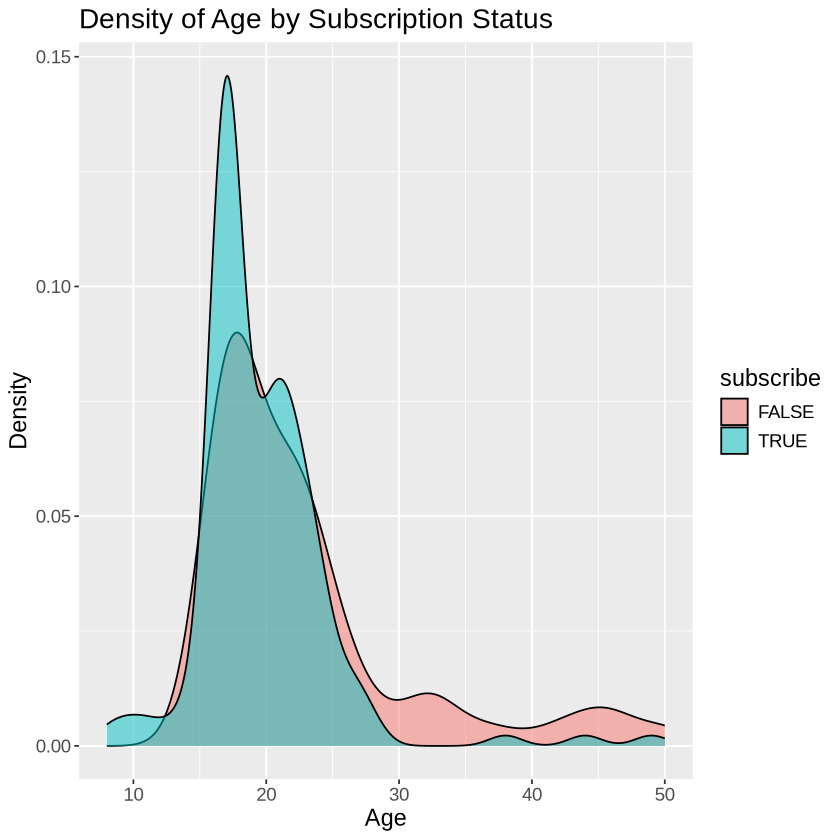

In [8]:
age_density_plot <- players_clean |>
  ggplot(aes(x = age, fill = subscribe)) +
  geom_density(alpha = 0.5) +
  labs(title = "Density of Age by Subscription Status",
       x = "Age",
       y = "Density") +
    theme(text = element_text(size = 14))

age_density_plot

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


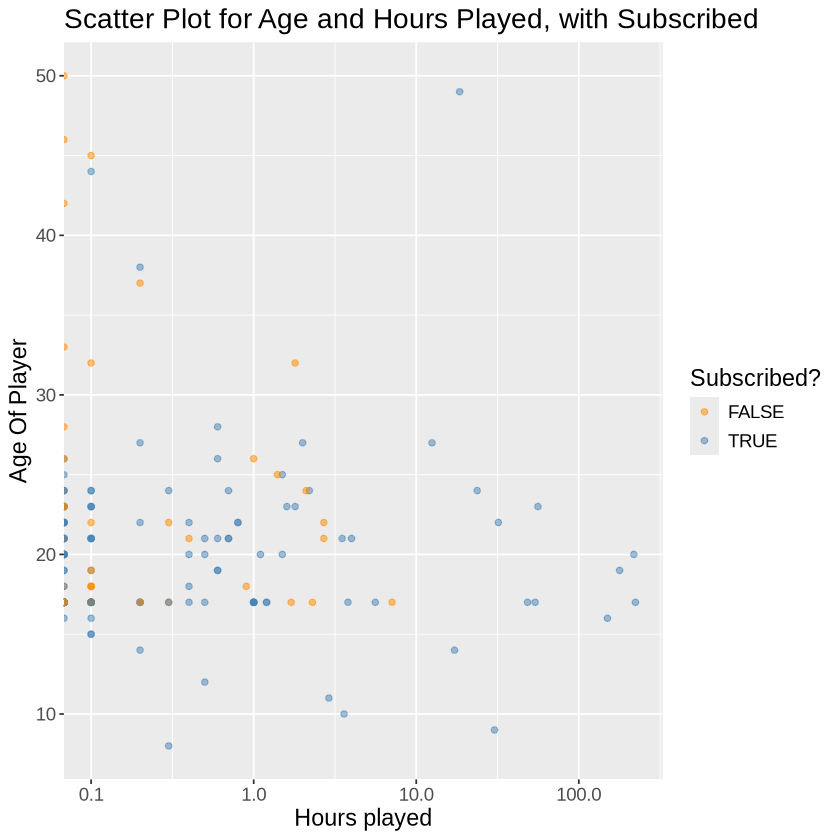

In [9]:
age_hours_scatter_plot <- players_clean |>
    ggplot(aes(x = played_hours, y = age, color = subscribe)) +
    geom_point(alpha=0.5) +
    scale_x_log10()+
    labs(x = "Hours played", 
         y = "Age Of Player", 
         color = "Subscribed?") +
            scale_color_manual(values = c("darkorange", "steelblue")) +
            ggtitle("Scatter Plot for Age and Hours Played, with Subscribed") + 
            theme(text = element_text(size = 14))

age_hours_scatter_plot

**KNN Cross Validation**

In [10]:
player_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


player_recipe <- recipe(subscribe ~ age + played_hours, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())



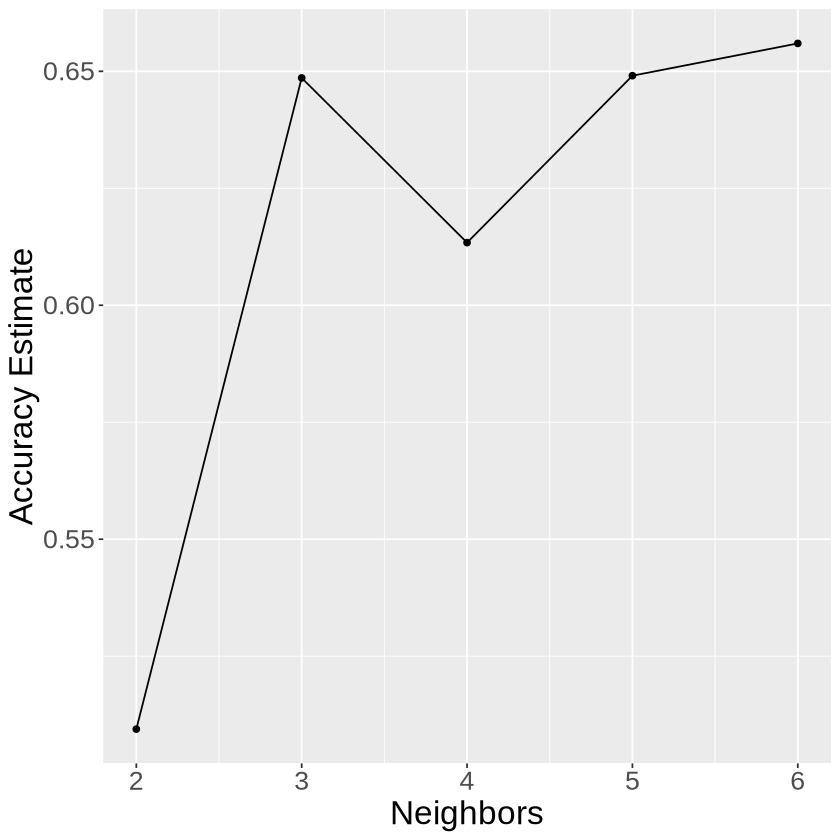

In [11]:
set.seed(123)

players_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
                 add_recipe(player_recipe) |>
                 add_model(player_spec) |>
                 tune_grid(resamples = players_vfold, grid = tibble(neighbors = c(2,3,4,5,6))) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 20))

cross_val_plot

***Players Model***

In [12]:
set.seed(9999)
tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
       set_engine("kknn") |>
       set_mode("classification")

player_fit <- workflow() |>
             add_recipe(player_recipe) |>
             add_model(tuned_spec) |>
            fit(data = player_train)
player_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(4,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4068966
Best kernel: rectangular
Best k: 4

***Testing Players Model***

In [13]:
player_predictions <- predict(player_fit, player_test) |>
                        bind_cols(player_test)

player_metrics <- player_predictions |> metrics(truth = subscribe, estimate = .pred_class)

player_conf_mat <- player_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
player_metrics
player_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.53061224
kap,binary,-0.02734731


          Truth
Prediction FALSE TRUE
     FALSE     5   15
     TRUE      8   21

### Notes 

I don't think that age and played_hours are good predicitors for subscription. There is a lot to be desired in the confusion matrix along with the accuracy of the possible K values for the neighbours, out of the 5 chosen, not one was above 60%. The amount of folds chosen was five, which is due to the small sample size of observations.

## Discussion

Our aim for this project was to assess whether the variables "age" and "hours played" could effectively predict whether or not a Minecraft player was subscribed to a Minecraft-related newsletter. To achieve this, we created visualizations to assess trends between the predictor variables and the subscription status, as well as conducted a K-nearest neighbours (KNN) regression analysis in order to determine the accuracy, precision, and recall of our model. After exploring this model's performance, questions have been raised on the validity of Age and Hours Played as predictors for subscription status. 

#### KNN Results 

The output from our KNN workflow gave us a minimal misclassification value of 0.4069 along with a best k value of 4. In particular, our minimal misclassification value is important, as it means that roughly 40.69% of the time, our test data was misclassified. More specifically, the overall accuracy of the model was 53.06%, the precision, which is the percent of subscription predictions that are actually correct, is 72.41% (  (true positives / (true positives + false positives)) = (21/(21+8)) = 0.7241  ) and the recall of the model, which is the percent of positive subscription predictions when compared to all actual positive subscriptions, is 58.33% (  (true positives / (true positives + false negatives)) = (21/(21+15)) = 0.58333). These results show that this model is clearly somewhat flawed, as its accuracy and recall are only slightly better than taking a random guess. The prediction of this model is marginally better, but that alone doesn't redeem its other inaccuracies. 

These results were mostly in line with our initial predictions, as the visualizations that we created prior to conducting our KNN analysis indicated that hours played and age didn't show a very clear trend in identifying subscription status. When looking at the histogram and density plots for played hours and subscription status, there appeared to be a slight positive relationship, with subscription increasing with higher played hours. However, this trend likely wouldn't be enough to accurately predict subscription status, as it is relatively weak. Additionally, our other predictor variable, player age, showed virtually no relationship to subscription status in our visualizations. Based off of our initial visualizations, it was fairly evident that our question wouldn't lead to an accurate or precise model, which was confirmed with KNN regression analysis. 

#### Implications of findings 

While our question didn't lead to an accurate prediction model, the implications of our findings are nonetheless still very relevant to the gaming industry. Our result, which is that player age and hours played together aren't a good predictor of subscription status, tells marketing companies that other predictor variables should be investigated , and that investments placed to target these demographics may be better spent elsewhere. For example, if future studies confirm that age and played hours aren't accurate predictors of subscription, marketing campaigns that are targeting young Minecraft players with high played hours may prove ineffective. 

#### Future questions

The results of our analysis suggest that different predictor variables should be investigated for their effectiveness in predicting subscription status. Using the datasets that we have been provided, investigating topics like the effectiveness of experience level, number of sessions played, or gender of the player on prediction of subscription status would be a logical next step. Additionally, the most accurate predictor variables for subscription status might not have been included in this study. Factors like in game purchases or social media activity, for example may provide a clearer prediction, so additional research is recommended. 



## Conclusion 

In this project, we examined whether "age" and "hours played" could predict whether a Minecraft player was subscribed to a Minecraft-related newsletter. Despite conducting visualizations and a KNN regression analysis, our results revealed that these two variables were not effective predictors. The model's accuracy, precision, and recall were notably low, confirming that the relationship between these variables and subscription status was weak. Consequently, the findings suggest that marketing efforts targeting age and hours played may not be effective. Future research should explore alternative predictors, such as player experience, in-game purchases, or social media activity, to better understand the factors influencing subscription status and improve predictive accuracy.